In [ ]:
import os
import fnmatch
import cv2 as cv
import string
import time

import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.client import device_lib

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
from google.colab import files

In [ ]:
dir_path = "/content/license-plates/"
list_labels = np.array(os.listdir(dir_path)) 

In [ ]:
print(len(list_labels))

100000


In [ ]:
labels = []
imgs = []
for label in list_labels:
    img = os.path.join(dir_path + '/' + label)
    imgs.append(img)
    label = label[:-4]
    new_label = ''
    for c in label:
        if c != '-':
            new_label += c
    labels.append(new_label)
    
print(labels[:10])

['27YLC04', '14V6807', '20K4681', '54PG298', '58RBM11', '26E8545', '70Z8893', '05ZM067', '77CB695', '17N1803']


In [ ]:
df = pd.DataFrame({'Path': imgs, 'Labels': labels})
print(df)

                                         Path   Labels
0      /content/license-plates//27-YLC-04.png  27YLC04
1      /content/license-plates//14-V-6807.png  14V6807
2      /content/license-plates//20-K-4681.png  20K4681
3      /content/license-plates//54-PG-298.png  54PG298
4      /content/license-plates//58-RBM-11.png  58RBM11
...                                       ...      ...
99995  /content/license-plates//79-NJ-560.png  79NJ560
99996  /content/license-plates//80-GIS-75.png  80GIS75
99997  /content/license-plates//18-BHA-41.png  18BHA41
99998  /content/license-plates//68-NYP-33.png  68NYP33
99999  /content/license-plates//60-HI-815.png  60HI815

[100000 rows x 2 columns]


In [ ]:
def plot_sample(df):
  plt.figure(figsize=(14,10))
  for i in range(20):
      random = np.random.randint(0,len(df))
      plt.subplot(4,5,i+1)
      plt.imshow(cv.imread(df.loc[random, 'Path']))
      plt.title(df.loc[random, 'Labels'], size = 10, color = "black") 
      plt.xticks([])
      plt.yticks([])
      
  plt.show()

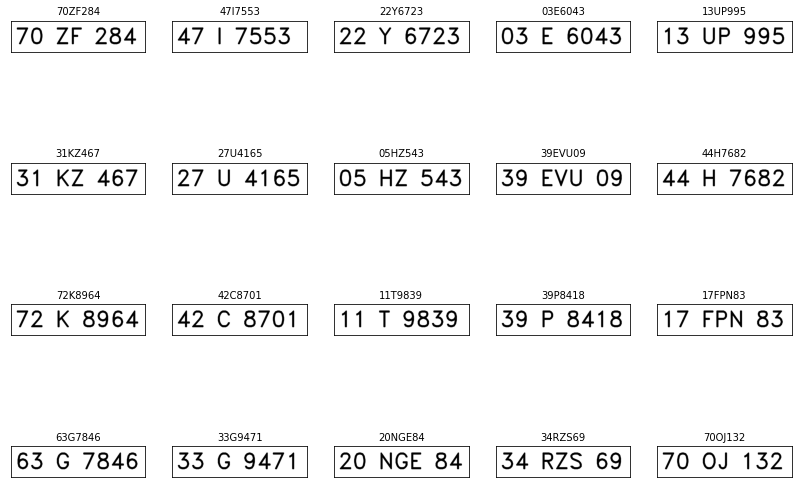

In [ ]:
plot_sample(df)

In [ ]:
Train_df, Test_df = train_test_split(df, test_size = 0.2, random_state = 101)
Train_df, Valid_df = train_test_split(Train_df, test_size = 1/4, random_state = 101)

In [ ]:
Train_df = Train_df.reset_index(drop = True)
Test_df = Test_df.reset_index(drop = True)
Valid_df = Valid_df.reset_index(drop = True)

In [ ]:
char_list = string.ascii_letters+string.digits

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return dig_lst

In [ ]:
# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 0

In [ ]:
test_img = []
test_txt = []
test_input_length = []
test_label_length = []
test_orig_txt = []

In [ ]:
for i in range(len(Test_df)):
    img = cv.imread(Test_df.loc[i, 'Path'], cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (128, 32))
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    txt = Test_df.loc[i, 'Labels']
    if len(txt) > max_label_len:
        max_label_len = len(txt)
    test_orig_txt.append(txt)   
    test_label_length.append(len(txt))
    test_input_length.append(31)
    test_img.append(img)
    test_txt.append(encode_to_labels(txt))

In [ ]:
for i in range(len(Train_df)):
    img = cv.imread(Train_df.loc[i, 'Path'], cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (128, 32))
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    txt = Train_df.loc[i, 'Labels']
    if len(txt) > max_label_len:
        max_label_len = len(txt)
    orig_txt.append(txt)   
    train_label_length.append(len(txt))
    train_input_length.append(31)
    training_img.append(img)
    training_txt.append(encode_to_labels(txt))

In [ ]:
print(len(training_img))

60000


In [ ]:
for i in range(len(Valid_df)):
    img = cv.imread(Valid_df.loc[i, 'Path'], cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (128, 32))
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    txt = Valid_df.loc[i, 'Labels']
    if len(txt) > max_label_len:
        max_label_len = len(txt)
    valid_orig_txt.append(txt)   
    valid_label_length.append(len(txt))
    valid_input_length.append(31)
    valid_img.append(img)
    valid_txt.append(encode_to_labels(txt))

In [ ]:
print(len(valid_img))

20000


In [ ]:
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [ ]:
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
crnn_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
crnn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 128, 64)  640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 64, 128)  73856       ['max_pooling2d[0][0]']    

In [ ]:
crnn_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [ ]:
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [ ]:
batch_size = 32
epochs = 10
crnn_model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
               y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, 
               validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], 
               [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 4.4968
Epoch 1: val_loss improved from inf to 10.08939, saving model to best_model.hdf5
1875/1875 [==============================] - 124s 57ms/step - loss: 4.4968 - val_loss: 10.0894
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0567
Epoch 2: val_loss improved from 10.08939 to 0.70753, saving model to best_model.hdf5
1875/1875 [==============================] - 105s 56ms/step - loss: 0.0568 - val_loss: 0.7075
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0165
Epoch 3: val_loss improved from 0.70753 to 0.00090, saving model to best_model.hdf5
1875/1875 [==============================] - 104s 55ms/step - loss: 0.0165 - val_loss: 8.9754e-04
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0317
Epoch 4: val_loss did not improve from 0.00090
1875/1875 [==============================] - 105s 56ms/step - loss: 0.0317 - val_loss: 0.0779
Epoch 

In [ ]:
# load the saved best model weights
act_model.load_weights('best_model.hdf5')
 
# predict outputs on validation images
prediction = act_model.predict(valid_img[:10])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 0
for x in out:
    print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

1/1 [==============================] - 0s 59ms/step
original_text =   26L7235
predicted text = 26L7235

original_text =   60HFI97
predicted text = 60HFI97

original_text =   10E7766
predicted text = 10E7766

original_text =   38F2060
predicted text = 38F2060

original_text =   43PJL92
predicted text = 43PJL92

original_text =   69FH672
predicted text = 69FH672

original_text =   15N2526
predicted text = 15N2526

original_text =   55H0191
predicted text = 55H0191

original_text =   42FSB02
predicted text = 42FSB02

original_text =   57RC278
predicted text = 57RC278



In [ ]:
model = '/content/best_model.hdf5'

In [ ]:
test_img = np.array(test_img)

In [ ]:
# load the saved best model weights
act_model.load_weights('best_model.hdf5')
 
# predict outputs on validation images
prediction = act_model.predict(test_img)
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 0
count = 0
for x in out:
    labels = ''
    for p in x:  
        if int(p) != -1:
            labels += char_list[int(p)]    
    if labels == test_orig_txt[i]:
        count += 1
    i += 1
print(count)

625/625 [==============================] - 8s 13ms/step
20000
